# Model Selection

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

Here is a list of models we will look at:

1. Logistic Regression

2. Logistic Regression with the Synthetic Minority Oversampling Technique (SMOTE)

3. Linear Discriminant Analysis (LDA)

4. Gaussian Naive Bayes

5. Principal Component Analysis (PCA) + K-Nearest Neighbors (KNN)

6. Principal Component Analysis (PCA) + Quadratic Discriminant Analysis (QDA)

7. Decision Tree Classifier

8. Random Forest Classifier

9. AdaBoost Classifier

10. XGBoost Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Loading the data

In [2]:
# load the data and drop TEAMS_LIST and POS rows
df = pd.read_csv("./train_data.csv").drop(columns=['TEAMS_LIST', 'POS'])

## Imputing and scaling

Note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from *only* that season and no other. In particular, since at the time of prediction we will have access to all of the data for that particular season, there is no data leakage occurring.

We impute all stats data with zeros, and fill missing salaries with the season's mean salary.  We define a custom `StandardScaler` which scales data within each season as well.

In [3]:
# check how many missing values in each column
len(df) - df.count()[df.count() < len(df)]

PER              3
TS_PERCENT      35
X3P_AR          40
F_TR            40
ORB_PERCENT      3
DRB_PERCENT      3
TRB_PERCENT      3
AST_PERCENT      3
STL_PERCENT      3
BLK_PERCENT      3
TOV_PERCENT     27
USG_PERCENT      3
WS_48            3
SALARY         568
dtype: int64

In [4]:
from ImputeAndScale import ImputeAndScale

In [5]:
df = ImputeAndScale(df)

Filling missing values for ['PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'WS_48'] with 0.
Filling missing SALARY data with season mean salary.
Apply StandardScaler to scale data within each season.


In [6]:
# check that it worked: randomly select a rescaled column, and check that the mean for each season
# is 0 and the standard deviation is 1
cols_to_rescale = df.select_dtypes(include=['float']).columns

# display numbers smaller than 1e-15 as 0
pd.set_option('display.chop_threshold', 1e-15)

random_rescaled_col = np.random.choice(cols_to_rescale)

print(f"Randomly selected rescaled column: {random_rescaled_col}")
df.groupby("SEASON_START")[random_rescaled_col].describe()[["mean", "std"]]

Randomly selected rescaled column: OBPM


,mean,std
SEASON_START,,
1990,0.000000e+00,1.001294
1991,0.000000e+00,1.001298
1992,0.000000e+00,1.001285
1993,0.000000e+00,1.001243
1994,0.000000e+00,1.001231
1995,0.000000e+00,1.001168
1996,0.000000e+00,1.001136
1997,0.000000e+00,1.001141
1998,0.000000e+00,1.001138


## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [7]:
df.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP',
       'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT',
       'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT',
       'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS',
       'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'SALARY', 'WAIVED', 'RELEASED',
       'TRADED', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF',
       'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG',
       'TRADED_POST', 'IN_LEAGUE_NEXT'],
      dtype='object')

In [8]:
# grab all columns
all_cols = list(df.columns)

# grab just the columns with numeric data
num_cols = df.select_dtypes(include='number').columns.drop('PLAYER_ID')

# grab just the predictors for later; NOTE: leaving out SEASON_START as a predictor
predictors = num_cols.drop(['SEASON_START', 'IN_LEAGUE_NEXT'])

In [9]:
predictors

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')

IN_LEAGUE_NEXT    1.000000
GP                0.505385
PF                0.460802
MIN               0.454275
FGA               0.396110
FGM               0.395826
PTS               0.391002
TOV               0.390322
WAIVED            0.378325
DREB              0.377827
STL               0.374977
REB               0.373683
DWS               0.364216
WAIVED_REG        0.355055
WS                0.351836
Name: IN_LEAGUE_NEXT, dtype: float64


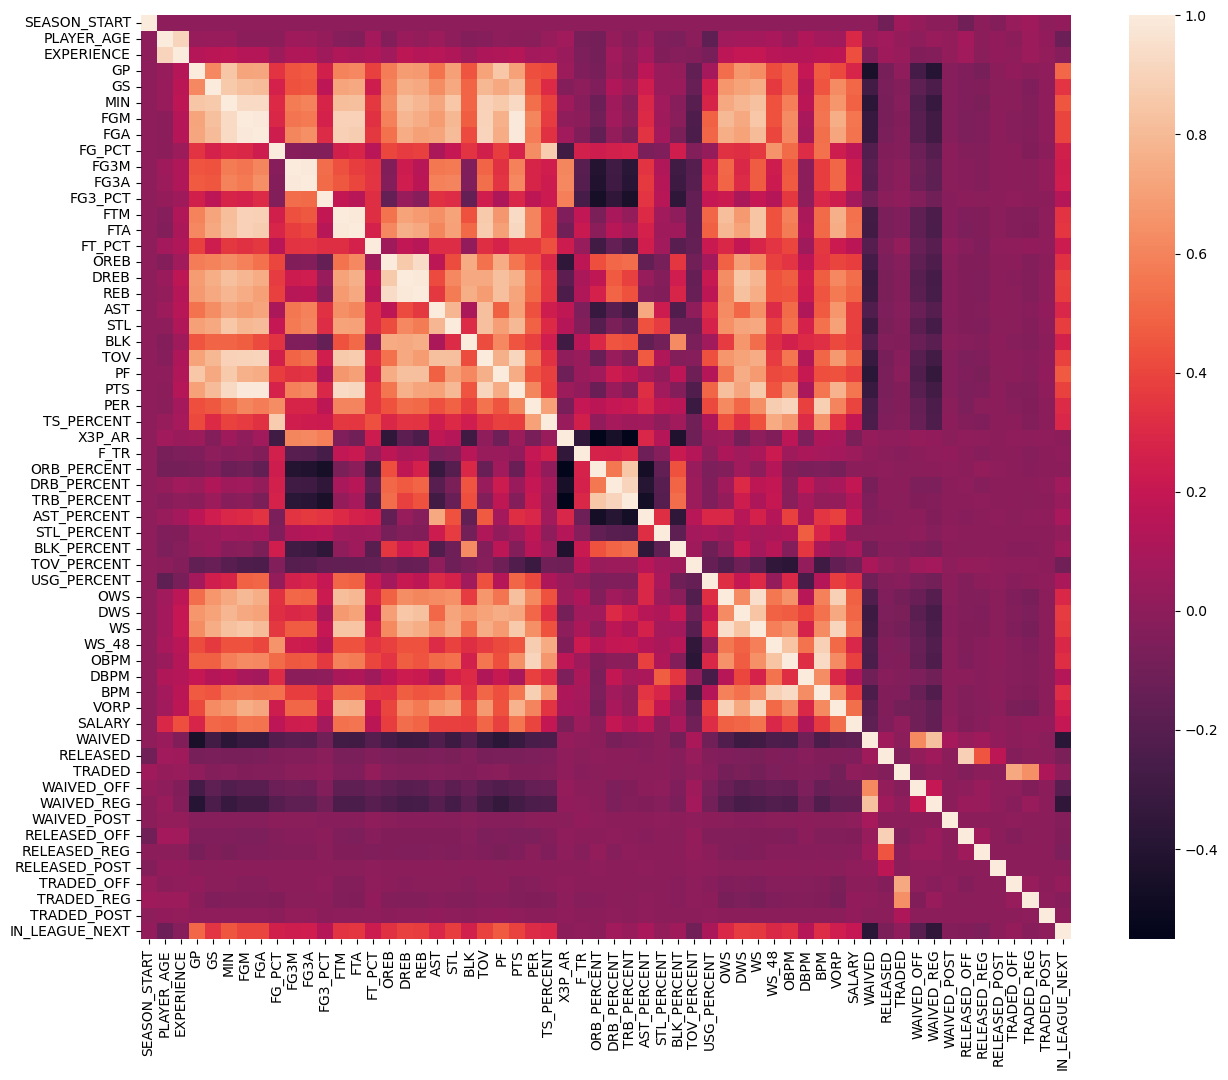

In [10]:
# compute correlations between numeric data columns
corr = df[num_cols].corr()

# print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
print(abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15])

# plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

## Split data into a training set and a calibration set

After choosing a model, we calibrate the model's predicted probabilities.  In order to do these two operations we need distinct sets of data; the model will be chosen and fit using `df_train`, and the model will be calibrated using `df_cal`.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_train, df_cal = train_test_split(df, test_size=0.1, random_state=815, 
                                    shuffle=True, stratify=df.IN_LEAGUE_NEXT)

df_train.reset_index(inplace=True)
df_cal.reset_index(inplace=True)

## Cross validation

We will use cross validation to evaluate the performance of our models. Moreover, we will use `GridSearchCV` to perform hyperparameter tuning.

In [13]:
from sklearn.model_selection import GridSearchCV

### Walk-forward validation

Since we aim to use known current-season player/stats data to predict whether a player is in the NBA in the future (next season), we have to worry about not introducing "future" data in the training/validation process.  For this reason we will use a time series approach to cross-validation known as "walk-forward validation" (with an expanding window).

Specifically, we will do a time series cross-validation with 5 splits to estimate the performance of each model we consider.  The splits will have the following structure:

| CV split | CV train set seasons | CV validation set seasons |
| ---      | ---                  | ---                       |
| 1        | 1990 - 2011          | 2012                      |
| 2        | 1990 - 2012          | 2013                      |
| 3        | 1990 - 2013          | 2014                      |
| 4        | 1990 - 2014          | 2015                      |
| 5        | 1990 - 2015          | 2016                      |

where the minimum size of a CV training set is that of the first split, which uses 79% of `df_train`; this is computed (along with the number of rows in the training/validation sets for each split) in the cell below.

In [14]:
# create list containing (train, val) split indices
cv = []

for year in range(2012, 2017):
    train_idxs = df_train[df_train['SEASON_START'] < year].index
    val_idxs = df_train[df_train['SEASON_START'] == year].index
    cv.append((train_idxs, val_idxs))

In [15]:
print(f"First split trains on {len(cv[0][0])/len(df_train)*100:.0f}% of df_train.\n")

for split in range(5):
    print(f"Split {split} has train size {len(cv[split][0])} and val. size {len(cv[split][1])}")

First split trains on 80% of df_train.

Split 0 has train size 8614 and val. size 414
Split 1 has train size 9028 and val. size 430
Split 2 has train size 9458 and val. size 444
Split 3 has train size 9902 and val. size 429
Split 4 has train size 10331 and val. size 437


### Performance metrics

Below we define a helper functions `avg_cv_metrics` and `print_cv_metrics` which compute and display, respectively, all of the measures of classifier performance we will use during the model selection process.

Since our classes are imbalanced (far more players stay in the NBA each year than leave), in most of our modeling approaches we will use the Synthetic Minority Oversampling Technique (SMOTE) from the `imblearn` library. We note that `imblearn` has a `Pipeline` object which extends that of `sklearn` and allows us to use this resampling technique inside of our pipelines.

In [16]:
# show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1    8716
0    2052
Name: count, dtype: int64

In [17]:
from CVHelpers import avg_cv_metrics, print_cv_metrics

## Comparing models

### Model 1: Logistic Regression

Let's begin by finding the CV performance of a simple logistic regression model on the training set.  We train this model without accounting for the fact that our classes (values of `IN_LEAGUE_NEXT`) are imbalanced.

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
log_reg = LogisticRegression(max_iter=10000)

param_grid = {'C': np.logspace(-4, 2, 7)}

grid_search = GridSearchCV(log_reg,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
       10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=10331),
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='balanced_accuracy')

In [20]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1.0}
0.7384551374683632


Classification metrics
Avg. bal. accuracy:	 0.7385
Avg. precision:		 0.8974
Avg. recall:		 0.9409
Avg. NPV:		 0.6787
Avg. specificity:	 0.536


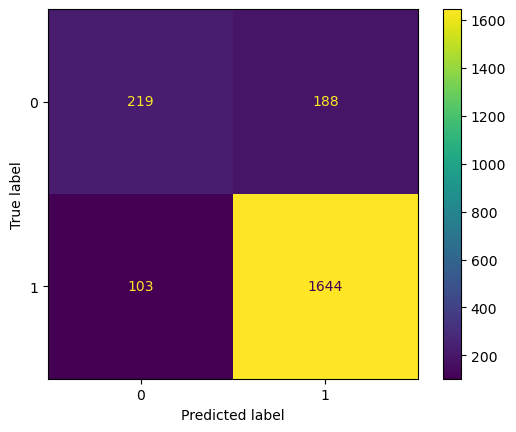

In [21]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

### Model 2: Logistic Regression with the Synthetic Minority Oversampling Technique (SMOTE)

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV split.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, we find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

In [24]:
from imblearn.pipeline import Pipeline                                          
from imblearn.over_sampling import SMOTE

In [25]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('log_reg', LogisticRegression(max_iter=10000))])

param_grid = {'log_reg__C': np.logspace(-4, 2, 7)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log_reg__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='balanced_accuracy')

In [26]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'log_reg__C': 0.001}
0.809837651116269


In [27]:
param_grid = {'log_reg__C': [0.0005, 0.00075, 0.001, 0.00125, 0.0015]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
      dtype='int64', length=10331),
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log_reg__C': [0.0005, 0.00075, 0.001, 0.00125,
                                        0.0015]},
             scoring='balanced_accuracy')

In [28]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'log_reg__C': 0.00075}
0.8141980123485091


Classification metrics
Avg. bal. accuracy:	 0.8142
Avg. precision:		 0.9604
Avg. recall:		 0.7629
Avg. NPV:		 0.4593
Avg. specificity:	 0.8655


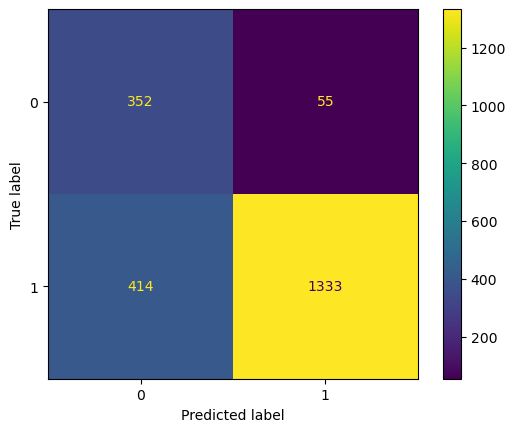

In [29]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Using SMOTE seems to give us a significance improvement in performance for logistic regression. That said, we have noticeably more false negatives after augmenting the data (notice the NPV is much worse).

### Model 3: Linear Discriminant Analysis (LDA)

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [29]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('lda', LinearDiscriminantAnalysis(solver='lsqr'))])

param_grid = {'lda__shrinkage': np.linspace(0, 1, 11)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('lda',
                                        LinearDiscriminantAnalysis(solver='lsqr'))]),
             param_grid={'lda__shrinkage': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='balanced_accuracy')

In [30]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'lda__shrinkage': 0.2}
0.8045513139138546


Classification metrics
Avg. bal. accuracy:	 0.8046
Avg. precision:		 0.9555
Avg. recall:		 0.7612
Avg. NPV:		 0.4523
Avg. specificity:	 0.8479


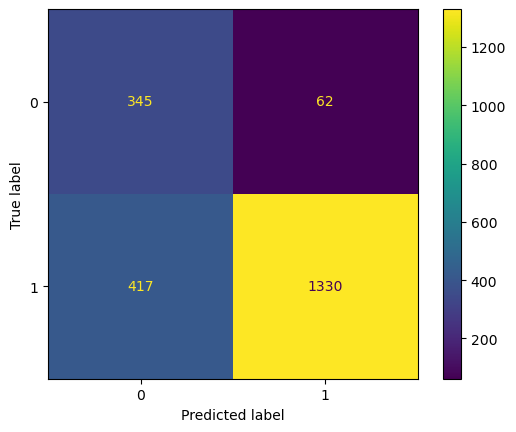

In [31]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

LDA is only slightly behind logistic regression with SMOTE (but has better precision and specificity).

### Model 4: Gaussian Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('gnb', GaussianNB())])

param_grid = {'gnb__var_smoothing': np.logspace(0,-9, num=10)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             scoring='balanced_accuracy')

In [34]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gnb__var_smoothing': 0.01}
0.7921560934357974


Classification metrics
Avg. bal. accuracy:	 0.7922
Avg. precision:		 0.9649
Avg. recall:		 0.6929
Avg. NPV:		 0.4034
Avg. specificity:	 0.8914


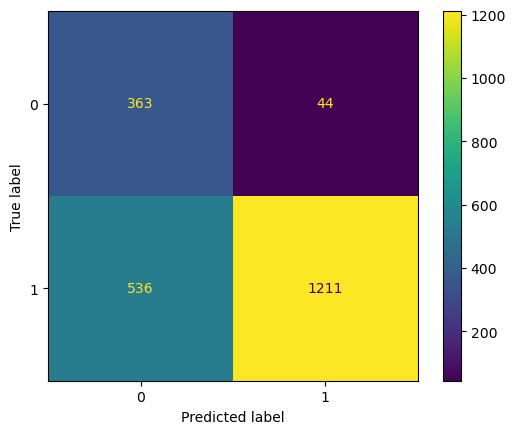

In [35]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Naive Bayes performs the worst so far (lowest balanced accuracy score, and NPV is really bad).

### Model 5: Principal Component Analysis (PCA) + K-Nearest Neighborhs (KNN)

Since KNN is suffers from the curse of dimensionality, we will likely need to reduce the number of predictors before using it; we can do so using PCA.

In [36]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

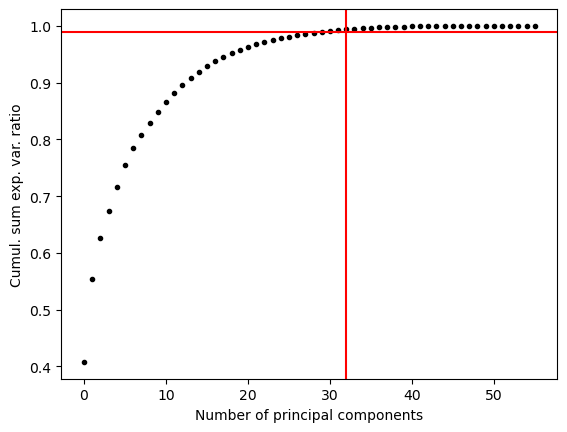

In [37]:
# scale the variables before applying PCA
pca = PCA(n_components=len(predictors))
pca.fit(df_train[predictors])

# grab the explained variance ratio
pca_EVR = pca.explained_variance_ratio_ #get the explained variance ratio

# get the cumulative sum of the explained variance ratio and plot it
pca_EVR_cumul = np.cumsum(pca_EVR)

plt.plot(pca_EVR_cumul, 'k.')
plt.xlabel("Number of principal components")
plt.ylabel("Cumul. sum exp. var. ratio")
plt.axhline(0.99, c='r')
plt.axvline(32, c='r')
plt.show()

From the plot we can see that it takes 32 principal components to explain 99% of the variance in the predictors.

In [38]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('knn', KNeighborsClassifier())])

param_grid = {'pca__n_components': range(25, 35),
              'knn__n_neighbors': range(50, 100)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

/home/alex/anaconda3/envs/nba_pred/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
      dtype='int64', length=10331),
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(50, 100),
                         'pca__n_components': range(25, 35)},
             scoring='balanced_accuracy')

In [39]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'knn__n_neighbors': 97, 'pca__n_components': 33}
0.8053889492087848


Classification metrics
Avg. bal. accuracy:	 0.8054
Avg. precision:		 0.9655
Avg. recall:		 0.7214
Avg. NPV:		 0.4262
Avg. specificity:	 0.8894


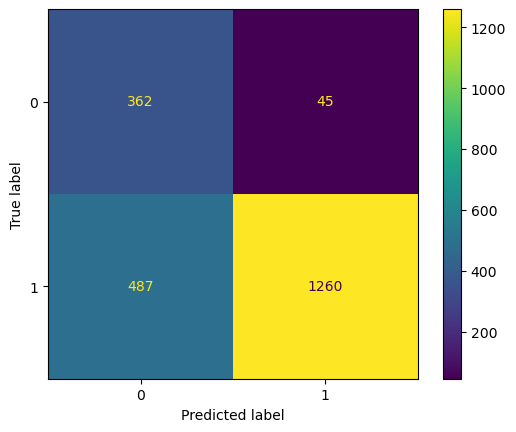

In [40]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

PCA + KNN performs similarly to LDA.

### Model 6: Principal Component Analysis (PCA) + Quadratic Discriminant Analysis (QDA)

QDA doesn't converge well if our predictors are colinear, as is the case here.  We'll use PCA to generate an orthogonal basis of predictors before using QDA.

In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [42]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('qda', QuadraticDiscriminantAnalysis())])

param_grid = {'pca__n_components': [30],
              'qda__reg_param': np.linspace(0,1,11)}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             param_grid={'pca__n_components': [30],
                         'qda__reg_param': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='balanced_accuracy')

In [43]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 30, 'qda__reg_param': 0.4}
0.8070485681382717


In [44]:
pipe = Pipeline([('pca', PCA()), ('smote', SMOTE(random_state=5)), ('qda', QuadraticDiscriminantAnalysis())])

param_grid = {'pca__n_components': range(25, 35),
              'qda__reg_param': [0.3]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
      dtype='int64', length=10331),
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('smote', SMOTE(random_state=5)),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             param_grid={'pca__n_components': range(25, 35),
                         'qda__reg_param': [0.3]},
             scoring='balanced_accuracy')

In [45]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'pca__n_components': 25, 'qda__reg_param': 0.3}
0.8079966001616498


Classification metrics
Avg. bal. accuracy:	 0.808
Avg. precision:		 0.9563
Avg. recall:		 0.7663
Avg. NPV:		 0.4585
Avg. specificity:	 0.8497


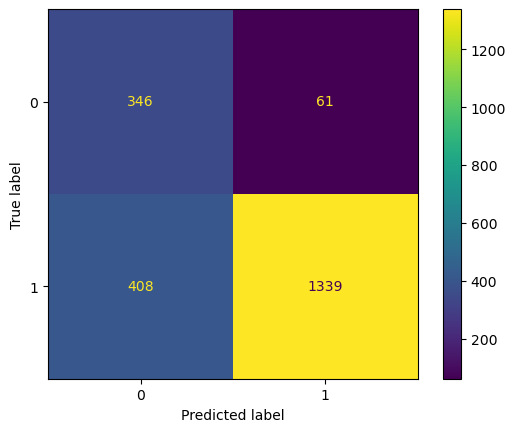

In [46]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

PCA + QDA performs _very_ similarly to logistic regression with SMOTE, just a tad bit worse.

## Model 7: Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('tree', DecisionTreeClassifier(random_state=25))])

param_grid = {'tree__criterion': ['gini', 'log_loss'],
              'tree__max_depth': [5, 10, 15, None]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=25))]),
             param_grid={'tree__criterion': ['gini', 'log_loss'],
                         'tree__max_depth': [5, 10, 15, None]},
             scoring='balanced_accuracy')

In [49]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'tree__criterion': 'gini', 'tree__max_depth': 5}
0.801843805869715


Classification metrics
Avg. bal. accuracy:	 0.8018
Avg. precision:		 0.9504
Avg. recall:		 0.7777
Avg. NPV:		 0.4643
Avg. specificity:	 0.826


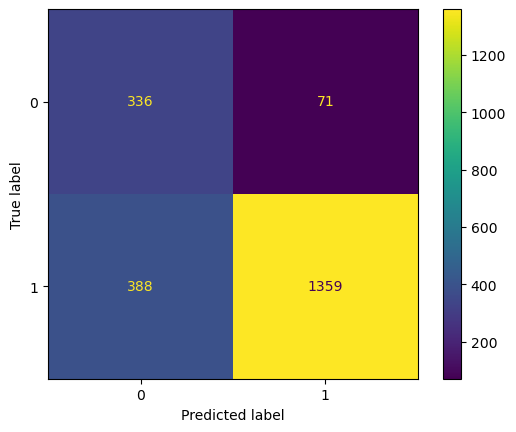

In [50]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Decision tree classifier performs slightly better than LDA (with significantly better NPV).

### Model 8: Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('rfc', RandomForestClassifier(random_state=25))])

param_grid = {'rfc__n_estimators': [50, 100, 250, 500],
              'rfc__max_depth': [5, 10, 20, None]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=3)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END rfc__max_depth=5, rfc__n_estimators=50;, score=0.797 total time=   1.6s
[CV 2/5] END rfc__max_depth=5, rfc__n_estimators=50;, score=0.841 total time=   1.7s
[CV 3/5] END rfc__max_depth=5, rfc__n_estimators=50;, score=0.823 total time=   1.8s
[CV 4/5] END rfc__max_depth=5, rfc__n_estimators=50;, score=0.792 total time=   1.7s
[CV 5/5] END rfc__max_depth=5, rfc__n_estimators=50;, score=0.777 total time=   1.8s
[CV 1/5] END rfc__max_depth=5, rfc__n_estimators=100;, score=0.797 total time=   3.2s
[CV 2/5] END rfc__max_depth=5, rfc__n_estimators=100;, score=0.841 total time=   3.5s
[CV 3/5] END rfc__max_depth=5, rfc__n_estimators=100;, score=0.827 total time=   3.4s
[CV 4/5] END rfc__max_depth=5, rfc__n_estimators=100;, score=0.789 total time=   3.5s
[CV 5/5] END rfc__max_depth=5, rfc__n_estimators=100;, score=0.781 total time=   3.7s
[CV 1/5] END rfc__max_depth=5, rfc__n_estimators=250;, score=0.796 total time=   7.4

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=25))]),
             param_grid={'rfc__max_depth': [5, 10, 20, None],
                         'rfc__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=3)

In [53]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'rfc__max_depth': 10, 'rfc__n_estimators': 250}
0.814115890281405


Classification metrics
Avg. bal. accuracy:	 0.8141
Avg. precision:		 0.9464
Avg. recall:		 0.8299
Avg. NPV:		 0.5233
Avg. specificity:	 0.7984


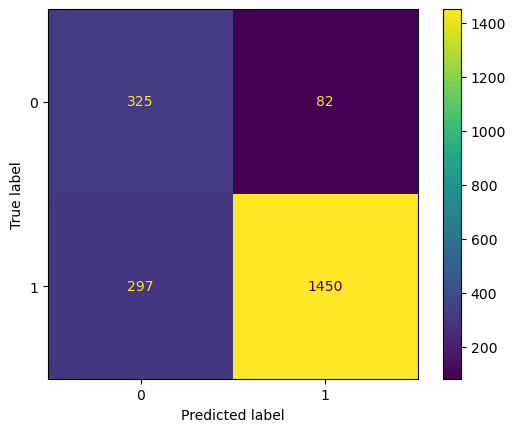

In [54]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

Random forest classifier has average balanced accuracy comparable to logistic regression with SMOTE (just 0.8% less), but with improved NPV (by about 2.5%). Trades some specificity for an increase in sensitivity (i.e., recall).

### Model 9: AdaBoost Classifier

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [30]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('ada', AdaBoostClassifier(algorithm='SAMME', random_state=25))])

param_grid = {'ada__n_estimators': [50, 100, 250, 500],
              'ada__learning_rate': [0.01, 0.1, 1]}
            #   'ada__base_estimator__max_depth': [1, 2, 3]}


grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=3)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ada__learning_rate=0.01, ada__n_estimators=50;, score=0.779 total time=   3.5s
[CV 2/5] END ada__learning_rate=0.01, ada__n_estimators=50;, score=0.825 total time=   3.7s
[CV 3/5] END ada__learning_rate=0.01, ada__n_estimators=50;, score=0.805 total time=   3.8s
[CV 4/5] END ada__learning_rate=0.01, ada__n_estimators=50;, score=0.808 total time=   4.0s
[CV 5/5] END ada__learning_rate=0.01, ada__n_estimators=50;, score=0.760 total time=   4.2s
[CV 1/5] END ada__learning_rate=0.01, ada__n_estimators=100;, score=0.785 total time=   6.9s
[CV 2/5] END ada__learning_rate=0.01, ada__n_estimators=100;, score=0.817 total time=   7.3s
[CV 3/5] END ada__learning_rate=0.01, ada__n_estimators=100;, score=0.795 total time=   7.7s
[CV 4/5] END ada__learning_rate=0.01, ada__n_estimators=100;, score=0.808 total time=   8.0s
[CV 5/5] END ada__learning_rate=0.01, ada__n_estimators=100;, score=0.769 total time=   8.4s
[CV 1/5] END a

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                  Index([    4,     5,   120,   126,   143,   148,   200,   228,   253,   304,
       ...
       10373, 10428, 10460, 10487, 10556, 10585, 10606, 10641, 10704, 10722],
      dtype='int64', length=437))],
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=5)),
                                       ('ada',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           random_state=25))]),
             param_grid={'ada__learning_rate': [0.01, 0.1, 1],
                         'ada__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=3)

In [31]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'ada__learning_rate': 1, 'ada__n_estimators': 500}
0.8137400646593151


Classification metrics
Avg. bal. accuracy:	 0.8137
Avg. precision:		 0.9499
Avg. recall:		 0.8108
Avg. NPV:		 0.5033
Avg. specificity:	 0.8167


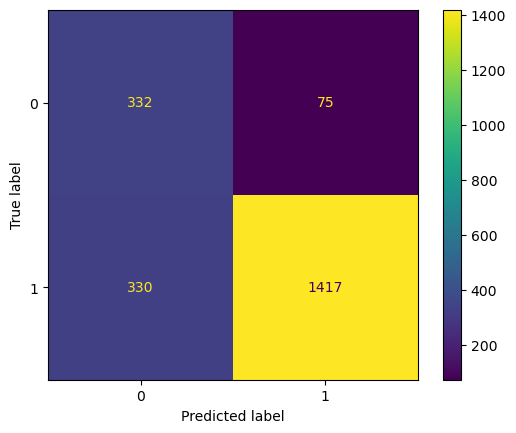

In [32]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

AdaBoost performs similar to decision tree classifier (better balanced accuracy, slightly worse NPV).

### XGBoost Classifier

In [33]:
from xgboost import XGBClassifier

In [34]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('xgb', XGBClassifier(random_state=25))])

param_grid = {'xgb__n_estimators': [50, 100, 250, 500],
              'xgb__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=3)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END xgb__learning_rate=0.001, xgb__n_estimators=50;, score=0.813 total time=   1.8s
[CV 2/5] END xgb__learning_rate=0.001, xgb__n_estimators=50;, score=0.807 total time=   0.2s
[CV 3/5] END xgb__learning_rate=0.001, xgb__n_estimators=50;, score=0.806 total time=   0.2s
[CV 4/5] END xgb__learning_rate=0.001, xgb__n_estimators=50;, score=0.773 total time=   0.2s
[CV 5/5] END xgb__learning_rate=0.001, xgb__n_estimators=50;, score=0.786 total time=   0.3s
[CV 1/5] END xgb__learning_rate=0.001, xgb__n_estimators=100;, score=0.816 total time=   0.4s
[CV 2/5] END xgb__learning_rate=0.001, xgb__n_estimators=100;, score=0.805 total time=   0.4s
[CV 3/5] END xgb__learning_rate=0.001, xgb__n_estimators=100;, score=0.803 total time=   0.4s
[CV 4/5] END xgb__learning_rate=0.001, xgb__n_estimators=100;, score=0.779 total time=   0.4s
[CV 5/5] END xgb__learning_rate=0.001, xgb__n_estimators=100;, score=0.784 total time=   0.4s
[CV

GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=25, ...))]),
             param_grid={'xgb__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'xgb__n_estimators': [50, 100, 250, 500]},
             scoring='balanced_accuracy', verbose=3)

In [35]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'xgb__learning_rate': 0.01, 'xgb__n_estimators': 100}
0.8113783659516909


In [36]:
pipe = Pipeline([('smote', SMOTE(random_state=5)), ('xgb', XGBClassifier(random_state=25))])

param_grid = {'xgb__n_estimators': [300, 350, 400, 450],
              'xgb__learning_rate': [0.005]}

grid_search = GridSearchCV(pipe,
                           param_grid=param_grid,
                           scoring='balanced_accuracy',
                           cv=cv,
                           verbose=3)
grid_search.fit(df_train[predictors], df_train['IN_LEAGUE_NEXT'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END xgb__learning_rate=0.005, xgb__n_estimators=300;, score=0.798 total time=   0.9s
[CV 2/5] END xgb__learning_rate=0.005, xgb__n_estimators=300;, score=0.832 total time=   0.9s
[CV 3/5] END xgb__learning_rate=0.005, xgb__n_estimators=300;, score=0.832 total time=   0.9s
[CV 4/5] END xgb__learning_rate=0.005, xgb__n_estimators=300;, score=0.804 total time=   0.9s
[CV 5/5] END xgb__learning_rate=0.005, xgb__n_estimators=300;, score=0.772 total time=   1.6s
[CV 1/5] END xgb__learning_rate=0.005, xgb__n_estimators=350;, score=0.799 total time=   1.2s
[CV 2/5] END xgb__learning_rate=0.005, xgb__n_estimators=350;, score=0.841 total time=   1.1s
[CV 3/5] END xgb__learning_rate=0.005, xgb__n_estimators=350;, score=0.838 total time=   1.1s
[CV 4/5] END xgb__learning_rate=0.005, xgb__n_estimators=350;, score=0.807 total time=   1.1s
[CV 5/5] END xgb__learning_rate=0.005, xgb__n_estimators=350;, score=0.774 total time=   1.2s


GridSearchCV(cv=[(Index([    1,     2,     3,     6,     7,     8,     9,    10,    11,    12,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765, 10766, 10767],
      dtype='int64', length=8614),
                  Index([    0,    25,    47,    56,    69,    72,    97,   104,   139,   181,
       ...
       10551, 10570, 10684, 10691, 10700, 10710, 10718, 10725, 10729, 10747],
      dtype='int64', length=414)),
                 (Index([    0,     1,     2,     3,     6,     7,     8,     9,    10,    11,
       ...
       10756, 10757, 10759, 10760, 10762, 10763, 10764, 10765,...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=25, ...))]),
             param_grid={'xgb__learning_rate': [0.005],
                         'xgb__n_estimators': [300, 350, 400, 450]},
             scoring='balanced_accuracy', verbose=3)

In [37]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'xgb__learning_rate': 0.005, 'xgb__n_estimators': 400}
0.8120842175748819


Classification metrics
Avg. bal. accuracy:	 0.8121
Avg. precision:		 0.9481
Avg. recall:		 0.8155
Avg. NPV:		 0.5055
Avg. specificity:	 0.8087


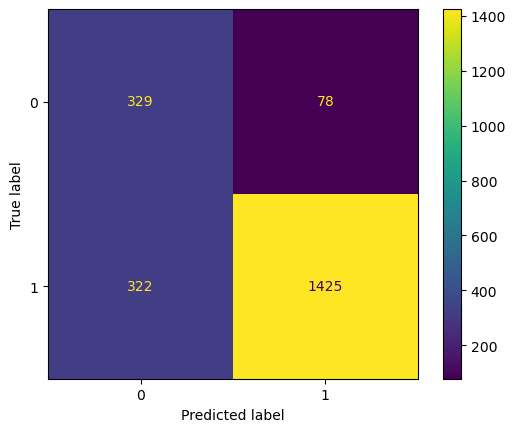

In [38]:
print_cv_metrics(grid_search.best_estimator_, df_train, predictors, cv)

XGBoost has the best balanced accuracy and the best NPV (except for logistic regression _without_ SMOTE, which has the worst balanced accuracy). Also, XGBoost has the most balanced sensitivity (i.e., recall) and specificity out of any of our models (random forest is close, but not quite as balanced).

## Summary and final model selection

We summarize the performance of our models in the following table, focusing first on balanced accuracy.

| Rank | Model | Balanced Accuracy | Precision | Recall (sensitivity) | NPV | Specificity | Hyperparameters |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | XGBoost Classifier | 0.8116 | 0.9482 | 0.8156 | 0.5041 | 0.8076 | `n_estimators=400, learning_rate=0.005` |
| 2 | Logistic Regression w/ SMOTE | 0.8079 | 0.9566 | 0.7654 | 0.4561 | 0.8503 | `C=0.00125` |
| 3 | Random Forest Classifier | 0.8071 | 0.9494 | 0.7971 | 0.4824 | 0.8170 | `n_estimators=50, max_depth=5` |
| 4 | PCA + KNN | 0.8065 | 0.9664 | 0.7211 | 0.4253 | 0.8920 | `pca__n_components=30, knn__n_neighbors=84` |
| 5 | PCA + QDA | 0.8051 | 0.9553 | 0.7649 | 0.4547 | 0.8453 | `pca__n_components=30`, `qda__reg_param=0.3` |
| 6 | AdaBoost Classifier | 0.8024 | 0.9498 | 0.7833 | 0.4674 | 0.8214 | `n_estimators=500, learning_rate=0.1` |
| 7 | Decision Tree Classifier | 0.8009 | 0.9485 | 0.7868 | 0.4710 | 0.8150 | `criterion='gini', max_depth=5` |
| 8 | LDA | 0.8009 | 0.9637 | 0.7189 | 0.4208 | 0.8828 | `shrinkage=0.8` |
| 9 | Gaussian Naive Bayes | 0.7876 | 0.9713 | 0.6593 | 0.3839 | 0.9158 | `var_smoothing=0.1` |
| 10 | Logistic Regression | 0.7308 | 0.8950 | 0.9385 | 0.6637 | 0.5232 | `C=1` |

Based on our findings, we will select an ***XGBoost Classifier (with SMOTE)*** with hyperparameters `n_estimators=400` and `learning_rate=0.005` as our final model. It has the highest balanced accuracy, and the best NPV (beside logistic regression without SMOTE, which is to be expected), and has the most balanced sensitivity (i.e., recall) and specificity.